In [1]:
import argparse
import logging
import math
import os
import random
import shutil
import yaml
import shutil
import json
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed

from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import sys
sys.path.append("./diffusers")

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, DDIMScheduler
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

from consistory_unet_sdxl import ConsistorySDXLUNet2DConditionModel
from consistory_pipeline import ConsistoryExtendAttnSDXLPipeline

import pickle

from projector import Projector

torch.autograd.set_detect_anomaly(True)

/workspace/oa_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/workspace/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/workspace/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# get environment configs
with open("PATH.json","r") as f:
    ENV_CONFIGS = json.load(f)

In [3]:
import yaml

with open("./config/gen_tune_inference.yaml", "r") as f:
    config = yaml.safe_load(f)
device = config['device']

In [4]:
accelerator_project_config = ProjectConfiguration(project_dir=config['output_dir']+'/'+config['dir_name'], logging_dir='logs')
accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision='no',
    log_with="tensorboard",
    project_config=accelerator_project_config,
)

/workspace/oa_venv/lib/python3.10/site-packages/accelerate/accelerator.py:401: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


In [5]:
# Make one log on every process with the configuration for debugging.
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if config['t_seed'] is not None:
    set_seed(config['t_seed'])

# Handle the repository creation
if accelerator.is_main_process:
    if config['output_dir'] is not None:
        os.makedirs(config['output_dir'], exist_ok=True)
        os.makedirs(config['output_dir']+'/'+config['dir_name'], exist_ok=True)            
        os.makedirs(config['output_dir']+'/'+config['dir_name']+'/ckpt', exist_ok=True)
        os.makedirs(config['output_dir']+'/'+config['dir_name']+'/weight', exist_ok=True)
    shutil.copyfile("./config/gen_tune_inference.yaml", config['output_dir']+'/'+config['dir_name']+'/config.yaml')

In [6]:
def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str = None, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")

In [7]:
# Load Models
pretrained_model_name_or_path = ENV_CONFIGS['paths']['sdxl_path']
# Load the tokenizers
tokenizer_one = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    revision=None,
    use_fast=False,
)
tokenizer_two = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer_2",
    revision=None,
    use_fast=False,
)

# import correct text encoder classes
text_encoder_cls_one = import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path, None
)
text_encoder_cls_two = import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path, None, subfolder="text_encoder_2"
)

/workspace/oa_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [8]:
# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
# Check for terminal SNR in combination with SNR Gamma
text_encoder_one = text_encoder_cls_one.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder",
)
text_encoder_two = text_encoder_cls_two.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder_2",
)

vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="vae",
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet",
)

/workspace/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
{'dynamic_thresholding_ratio', 'clip_sample_range', 'rescale_betas_zero_snr', 'variance_type', 'thresholding'} was not found in config. Values will be initialized to default values.
{'dropout', 'attention_type', 'reverse_transformer_layers_per_block'} was not found in config. Values will be initialized to default values.


In [9]:
vae.requires_grad_(False)
text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)
unet.requires_grad_(False)

# Build projector
projector = Projector(1280, 2048)
# Fire projector
projector.requires_grad_(True)


Projector(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1280, 640, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Residual(
        (conv1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Residual(
        (conv1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): Ba

In [10]:
if config['use_xformers']:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

In [11]:
unet.enable_xformers_memory_efficient_attention()

In [17]:
class OneActorDataset(Dataset):
    def __init__(
        self,
        config,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
    ):
        self.data_root = config['data_root'] + "/" + config['dir_name']
        self.learnable_property = config['concept_type']
        self.size = config['size']
        self.base_condition = config['base_condition']
        self.flip_p = flip_p
        self.neg_num = config['neg_num']

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root) if os.path.splitext(file_path)[1] == '.jpg']
        self.base_root = self.data_root + '/base'
        self.base_paths = [os.path.join(self.base_root, file_path) for file_path in os.listdir(self.base_root) if os.path.splitext(file_path)[1] == '.jpg']

        self.num_images = len(self.image_paths)
        self.num_base = len(self.base_paths)
        self._length = self.num_images * 2

        if set == "train":
            self._length = self.num_images * repeats * 2

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]
        if self.learnable_property == 'character':
            self.templates = human_templates
        elif self.learnable_property == 'object':
            self.templates = imagenet_templates_small
        elif self.learnable_property == 'style':
            self.templates = imagenet_style_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)    # randomly flip images

        with open(self.data_root+'/xt_list.pkl', 'rb') as f:
            xt_dic = pickle.load(f)

        self.h_mid = xt_dic['h_mid']
        self.prompt_embed = xt_dic['prompt_embed']

        with open(self.base_root+'/mid_list.pkl', 'rb') as f:
            self.base_mid = pickle.load(f)


    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}

        img_paths = []
        h_mid_list = []
        # target samples
        target_img_path = random.choice(self.image_paths)
        img_paths.append(target_img_path)
        print(target_img_path)
        h_mid_list.append(self.h_mid[-1])
        # base samples
        for i in range(self.neg_num):
            ind = random.randint(0, len(self.base_paths)-1)
            base_img_path = self.base_paths[ind]
            img_paths.append(base_img_path)
            h_mid_list.append(self.base_mid[ind])
        h_mid_list.append(random.choice(h_mid_list))
        
        img_tensors = []
        text_list = []
        for img_path in img_paths:

            image = Image.open(img_path)

            if not image.mode == "RGB":
                image = image.convert("RGB")
            # default to score-sde preprocessing
            img = np.array(image).astype(np.uint8)

            image = Image.fromarray(img)
            image = image.resize((self.size, self.size), resample=self.interpolation)
            image = self.flip_transform(image)
            image = np.array(image).astype(np.uint8)
            image = (image / 127.5 - 1.0).astype(np.float32)
            img_tensors.append(torch.from_numpy(image).permute(2, 0, 1))

            text = random.choice(self.templates).format(self.base_condition)
            print(text)
            text_list.append(text)
        img_tensors.append(img_tensors[0])
        text_list.append(text_list[0])

        example["pixel_values"] = torch.stack(img_tensors)
        example['text'] = text_list
        example['base'] = self.base_condition
        example['h_mid'] = torch.stack(h_mid_list)
    
        return example


In [18]:
PIL_INTERPOLATION = {
    "linear": PIL.Image.Resampling.BILINEAR,
    "bilinear": PIL.Image.Resampling.BILINEAR,
    "bicubic": PIL.Image.Resampling.BICUBIC,
    "lanczos": PIL.Image.Resampling.LANCZOS,
    "nearest": PIL.Image.Resampling.NEAREST,
}

In [19]:
human_templates = [
    "a photo of a {}",
    "a portrait of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a beautiful {}",
    "a realistic photo of a {}",
    "a dark photo of the {}",
    "a character photo of a {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a face photo of the {}",
    "a cropped face of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a high-quality photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "an image of a {}",
    "a snapshot of a {}",
    "a person's photo of a {}",
    "an individual's photo of a {}",
]

In [20]:
if config['allow_tf32']:
    torch.backends.cuda.matmul.allow_tf32 = True

# Initialize the optimizer
optimizer = torch.optim.AdamW(
    projector.parameters(),  # only optimize the embeddings
    lr=config['lr'],
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-8,
)

# Dataset and DataLoaders creation:
train_dataset = OneActorDataset(
    config=config,
    set='train',
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0
)


In [21]:
train_dataset[0]['h_mid'][0].size()

data/demo/a_rugger_adventurer_with_tousled_hair_comic_book_stile/source.jpg
a face photo of the adventurer
a photo of the clean adventurer
an individual's photo of a adventurer
a portrait of a adventurer


torch.Size([2, 1280, 32, 32])

data/demo/a_rugger_adventurer_with_tousled_hair_comic_book_stile/source.jpg
the photo of a adventurer
the photo of a adventurer
a snapshot of a adventurer
a cropped photo of the adventurer
data/demo/a_rugger_adventurer_with_tousled_hair_comic_book_stile/source.jpg
a close-up photo of a adventurer
a rendition of a adventurer
a photo of the cool adventurer
the photo of a adventurer
data/demo/a_rugger_adventurer_with_tousled_hair_comic_book_stile/source.jpg
a rendition of a adventurer
a portrait of a adventurer
a cropped face of a adventurer
a photo of a nice adventurer


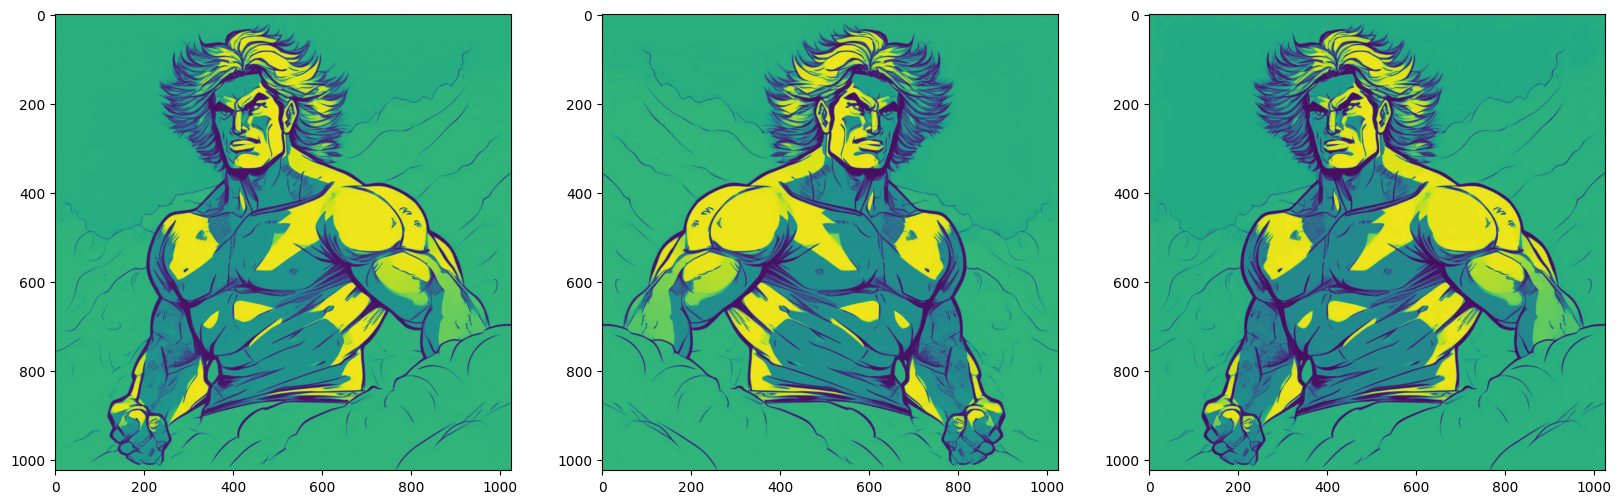

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
for n in range(3):
    axarr[n].imshow(train_dataset[0]['pixel_values'][4][n])